In [4]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
fetch_housing_data()

In [6]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [11]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [12]:
housing.describe(include = "O")

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

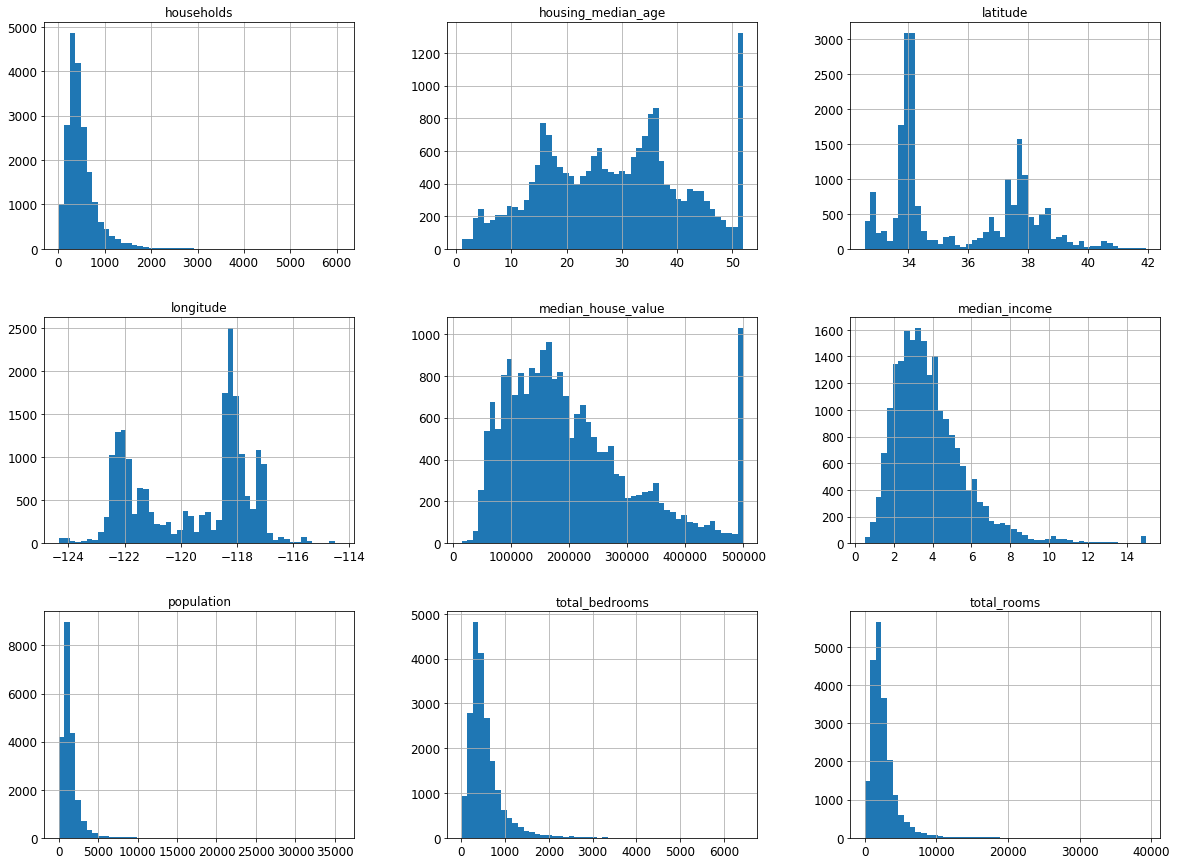

In [15]:
housing.hist(bins = 50, figsize = (20,15))
plt.show()

There's an issue in data collected in feature "house median age" and "median_house_value".

As the value beyond 50 and 500000 respectively cannot be tracked and recorded properly

--> Action: Remove those districs from the trainingn set, as we aren't going to give trustful prediction with house price > 500k, if we keep those samples.

In [17]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [18]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [19]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [20]:
len(test_set)

4128

In [21]:
#Test set will remain consistent across multiple runs, even if dataset is refreshed.
# The nnew test set will not contain any instance that was previously in the trainning set, 
# thanks to the identifier of each instance, in this case is the row index because we dont have house_ID for each instance.

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [22]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [23]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [24]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [25]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [26]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [36]:

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

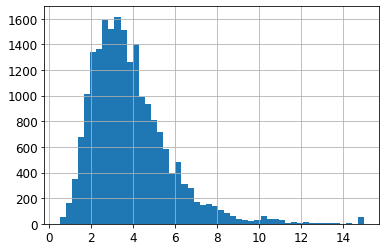

In [37]:
housing["median_income"].hist(bins = 50)

In [38]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [39]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

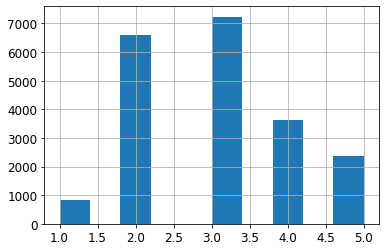

In [40]:
housing["income_cat"].hist()

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [42]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [43]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [44]:


def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [45]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


Comparison of income category proportions in the full dataset, test data set generated by stratified sampling and test set generated using purely random sampling method.

We can see that test set generated using stratified sampling has income category proportions almost identical to those in full dataset, so that test set is the perfect representative for the full dataset for us to test the model.

In [46]:
# Remove the income_cat from datasets as we dont need it anymore
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


### Exploratory Data Analysis

In [47]:
housing = strat_train_set.copy()

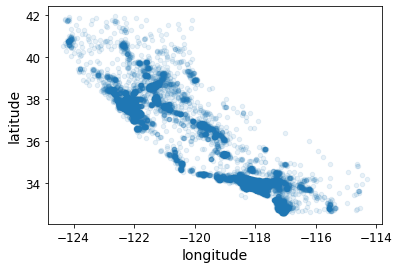

In [49]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha = 0.1)

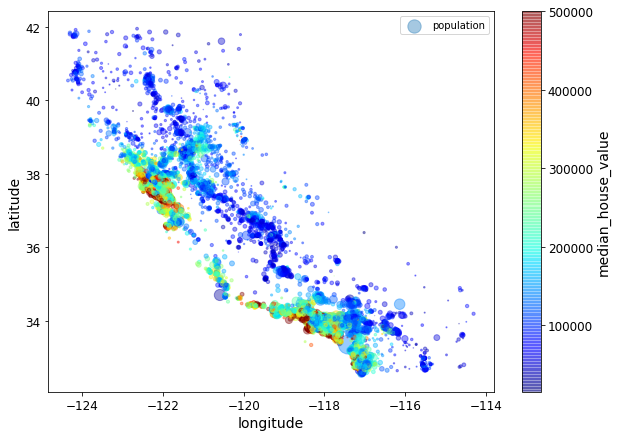

In [50]:
#Add median_house_price dimention to the above graph
#cmap: color map, "jet": color range from blue (low) to red (high)

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [51]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x1a2035f6d8>)

Saving figure california_housing_prices_plot


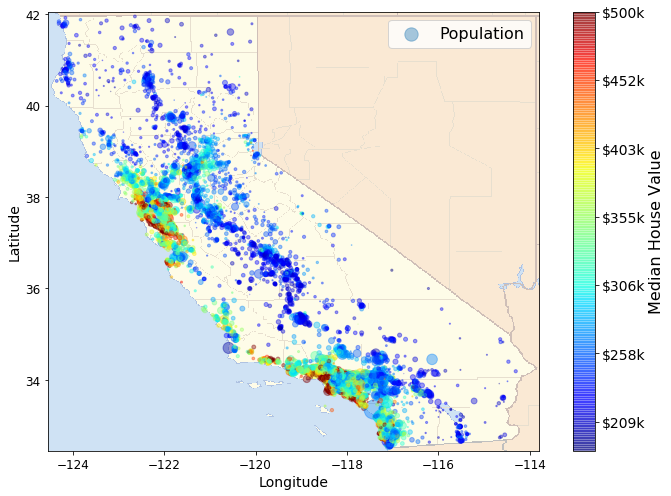

In [53]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [55]:
#Since the dataset is not too large, we can compute the standard correlation coefficient 
# between every pair of attributes using the corr() method
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


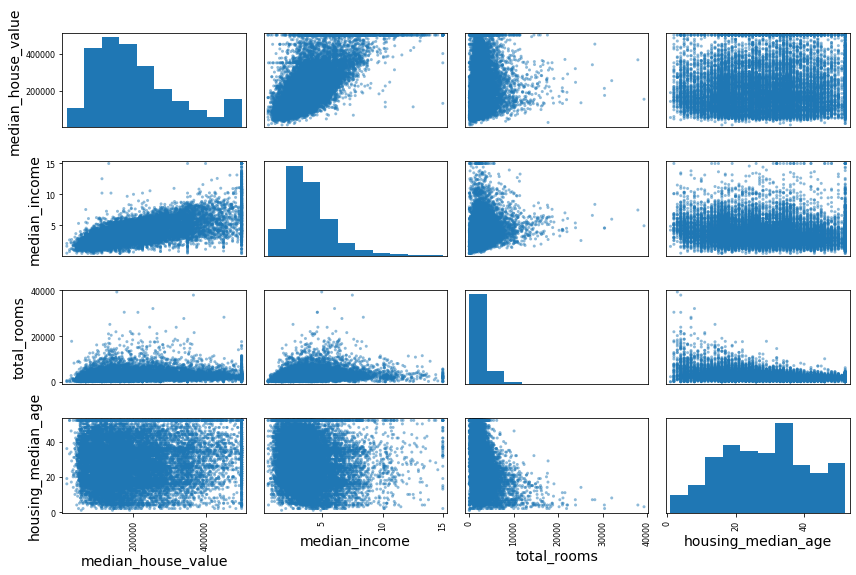

In [56]:
#Sinnce there are now 11 numerical attributes, you would get 121 plots, 
# so let's just focus on some promising attribues that seem most correlated with the median housing value

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

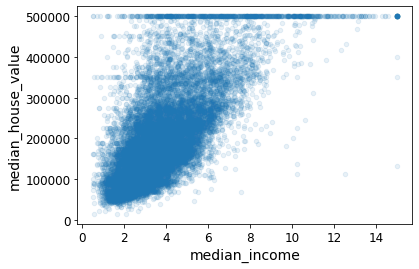

In [57]:
#The most promising attribute to predict the median house value is the median income

housing.plot(kind = "scatter",x = "median_income", y = "median_house_value", alpha = 0.1)

The correlation between them is indeed very strong.
But there are some horizontal lines in location of 500k, 450k, 350k and around 280k, we may want to remove the corresponding district to prevent the model from learning them to avoid repeoduce these data quirks

In [ ]:
# The total nummber of rooms in a district is not very useful, 
# and the same goes for the total number of bed rooms



In [58]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [59]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new attribute "bedrooms per room" has more correlation with house price compare to the total number of room

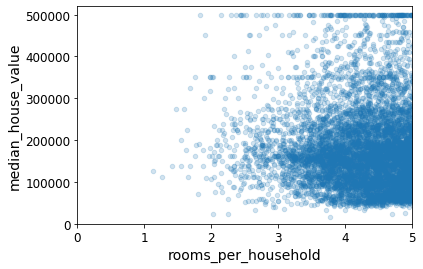

In [60]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

## Prepare the Data for Machine learning Algorithms

In [61]:
# Separate the predictors and the labels datasets
housing = strat_train_set.drop("median_house_value",axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data cleaning

In [62]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [63]:
# total_bedrooms attribute has some missing values, so let's fix this.

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [65]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [66]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [69]:
# option 3
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) 
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [70]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [71]:
#Remove the text attribute because median can only be calculated on numerical attributes

housing_num = housing.drop("ocean_proximity",axis = 1)
#housing_num = housing.select_dtypes(include = [np.number])

In [72]:
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

imputer has simply computed the median of each attribute and strore the result in its statistics_instance variable.

In [73]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [74]:
# Transform the training set by replaceing the missingn values with calculated median

X = imputer.transform(housing_num)

In [76]:
# Put X back to Dataframe format

housing_tr = pd.DataFrame(X, columns = housing_num.columns,index = housing_num.index)

In [77]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625


### Handling Text and Categorical Attributes

In [78]:
housing_cat = housing[["ocean_proximity"]]

In [79]:
housing_cat.head(5)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [81]:
#convert categorical values to number values
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()
housing_cat_encoded = oe.fit_transform(housing_cat)

In [82]:
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [83]:
#Get the list containning a 1D array of categories for each categorical attribute

oe.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this encoder is that ML algorithms will assume that two nearby values are mmore similar than two distannt values.

To fix this issue, a common solution is to create one binnary attribute per category.

--> one-hot encodinng: because only one attribute will be equal to 1 (hot)


In [85]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is a SciPy sparse matrix instead of a numpy array,
which stores only the location of the nonzero elements

In [86]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [87]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### Create a custom transformer to add extra attributes

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [89]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Feature scaling

Note:  ML algorithms dont perform well when the input numerical attributes have very different scales.

The are two common ways to get all attributes to have the same scale:
    - min-max scaling
    - standardizationn
    
 Standardization is much less affected by outliers

### Transformation Pipelines: 
there are many data transformation steps that need to be executed in the right order.

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy = "median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [92]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [95]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num",num_pipeline, num_attribs),
    ("cat", OneHotEncoder(),cat_attribs)
])

housing_prepared= full_pipeline.fit_transform(housing)

## Select and train a Model

### Training and evaluating on the training set

In [96]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [97]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [98]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [99]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [100]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [103]:
#Validation with train set only
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [104]:
# Get more precise evaluation using cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,
                        scoring = "neg_mean_squared_error",cv = 10)

tree_rmse_scores = np.sqrt(-scores)

In [106]:
def display_scores(scores):
    print("Scores: ",scores)
    print("Mean: ",scores.mean())
    print("Standard deviation: ",scores.std())

In [107]:
display_scores(tree_rmse_scores)

Scores:  [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean:  70666.74616904806
Standard deviation:  2928.322738055112


Now the Decision Tree doesn't look as good as it did earlier.

Infact, it seemms to perform worse than the Linear Regression model

In [108]:
#Let's check Linear Reg model again with cross_val_score

lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels,
                            scoring = "neg_mean_squared_error",cv = 10)

In [111]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [112]:
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.6740017983493


It seems that Decision Tree model is overfitting so badly that it performs worse than the Linear model

In [113]:
#Let's try the Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)

/Users/cuongthan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [114]:
forest_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,
                            scoring = "neg_mean_squared_error",cv = 10)

In [115]:
forest_rmse_scores = np.sqrt(-forest_scores)

In [116]:
display_scores(forest_rmse_scores)

Scores:  [52868.21871547 49194.92340594 51713.77716246 55012.10310441
 50973.88861214 55990.4479905  52298.68285092 50953.09058463
 54428.48087563 53461.73225682]
Mean:  52689.53455589254
Standard deviation:  1980.36257012708


In [117]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [118]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

### Fine-Tune your model

In [119]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

This param_grid tells scikitlearn to first evaluate all 3x4 =12 combinationns of n_estimators and max_features hyperparameter values.

then it will try all 1x2x3 = 6 combinations of hyperparameter values in the second dict

So there will be 90 rounds of training ((12 +6)x5) with 5 is the number of folds.

In [120]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [121]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [122]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

The grid search approach is fine when we are exploring relatively few combinations.

But when the hyperparameter search space is large, it is often preferable to to use RandomizedSearchCV

In [123]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a22502a20>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a23555908>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [124]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [125]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

We can oftenn gain good insights on the problem by inspecting the best model.

The RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions

In [126]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

## Evalute the model on the test set

Get the predictors and labels from the test set, 

run the full_pipeline to transform the data and then make evaluation

In [127]:
final_model = grid_search.best_estimator_

In [128]:
X_test = strat_test_set.drop("median_house_value",axis = 1)
y_test = strat_test_set["median_house_value"].copy()

In [131]:
X_test_prepared = full_pipeline.transform(X_test)

In [132]:
final_predictions = final_model.predict(X_test_prepared)

In [134]:
final_mse = mean_squared_error(y_test,final_predictions)

In [135]:
final_rmse = np.sqrt(final_mse)

In [136]:
final_rmse

47730.22690385927

compute 95% confidence interval for the generalization error using scipy.stats.t.interval()

In [138]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence,len(squared_errors)-1,
                        loc = squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])